**Logistic regression analysis with ADAM optimization for different learning rates, regularization types, and regularization parameters.**

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import martine.functions_martine as fun
import martine.NeuralNetwork as NN
import pandas as pd

from pathlib import Path
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions.make_dataset import *
from functions.nn_pytorch import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import LabelEncoder

In [2]:
np.random.seed(2018)
seed = 2018

In [3]:
"""
# Import data
path = '/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/kagglehub/datasets/nikhil7280/weather-type-classification/versions/1/weather_classification_data.csv'
df = pd.read_csv(path)

# Define targets and features
y = df["Weather Type"].copy()
X = df.drop(columns=["Weather Type"]).copy()

# Label-encode categorical features (NOT one-hot)
categorical_cols = ["Cloud Cover", "Season", "Location"]
encoders = {}

for col in categorical_cols:
    enc = LabelEncoder()
    X[col] = enc.fit_transform(X[col])
    encoders[col] = enc   # store in case you need to encode future data

# Encode target labels
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# One-hot target labels
y_onehot = np.eye(len(target_encoder.classes_))[y]

# Convert to numpy arrays
X = X.astype(float).values   # shape (n_samples, 10)
y = np.array(y)
 
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First X row:", X[0])
print("Feature names:", list(df.drop(columns=['Weather Type']).columns))
print("Target classes:", target_encoder.classes_)
"""


'\n# Import data\npath = \'/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/kagglehub/datasets/nikhil7280/weather-type-classification/versions/1/weather_classification_data.csv\'\ndf = pd.read_csv(path)\n\n# Define targets and features\ny = df["Weather Type"].copy()\nX = df.drop(columns=["Weather Type"]).copy()\n\n# Label-encode categorical features (NOT one-hot)\ncategorical_cols = ["Cloud Cover", "Season", "Location"]\nencoders = {}\n\nfor col in categorical_cols:\n    enc = LabelEncoder()\n    X[col] = enc.fit_transform(X[col])\n    encoders[col] = enc   # store in case you need to encode future data\n\n# Encode target labels\ntarget_encoder = LabelEncoder()\ny = target_encoder.fit_transform(y)\n\n# One-hot target labels\ny_onehot = np.eye(len(target_encoder.classes_))[y]\n\n# Convert to numpy arrays\nX = X.astype(float).values   # shape (n_samples, 10)\ny = np.array(y)\n \nprint("X shape:", X.shape)\nprint("y shape:", y.shape)\nprint("First X row:", X[0])\nprint("Feature names:", 

In [4]:
path = '/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/kagglehub/datasets/nikhil7280/weather-type-classification/versions/1/weather_classification_data.csv'
data = pd.read_csv(path)

K = 4 # number of classes

# Identify categorical columns
cat_cols = data.select_dtypes(include=["object"]).columns

# Create label encoders for each categorical column
encoders = {col: LabelEncoder() for col in cat_cols}

# Apply encoding
# String to numerical conversion
for col in cat_cols:
    data[col] = encoders[col].fit_transform(data[col]).astype(int)

X = data.drop('Weather Type', axis=1).values
y = data['Weather Type'].values

inputs = X
targets = np.zeros((len(y), K))
for i, t in enumerate(y):
    targets[i, t] = 1

In [5]:
# vary learning rate (no regularization)

netas = 4 #number of different learning rates
etas = np.logspace(-4, -1, netas)

# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([netas])
acc_test_matrix_no_reg = np.zeros([netas]) 

# split data into training and test data
X_train, X_test, t_train, t_test = train_test_split(inputs, targets, test_size=0.2, random_state=seed)

# scale data
#X_train, X_test = fun.scale_data(X_train, X_test, "classifier")
# Scale inputs only (standard for classifiers)
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define network architecture
network_input_size = X_train.shape[1]
layer_output_sizes1 = [K]

hidden_func = None
output_func = fun.Softmax()
cost_func = fun.CCE()

# set parameters
epochs = 20
M = 128
rho1, rho2 = 0.9, 0.999

# create model object
model = NN.NeuralNetwork(network_input_size, layer_output_sizes1, hidden_func, output_func, cost_func, seed = seed)

activation_funcs = model.activation_list()

# loop through learning rates
for i in range(netas):
    eta = etas[i]

    # set learning rate scheduler
    scheduler = fun.ADAM(eta, rho1, rho2)

    # create/reset layers
    layers = model.create_layers()

    # train network using only training data and stochastic gradient descent
    updated_layers = model.train_network_SGD(X_train, layers, activation_funcs, t_train, scheduler, epochs, M)

    # evaluate model on training and test data
    train_metrics = model.evaluate(X_train, updated_layers, activation_funcs, t_train)
    test_metrics = model.evaluate(X_test, updated_layers, activation_funcs, t_test)
        
    # calculate accuracy score
    acc_train_matrix_no_reg[i] = train_metrics["accuracy"] #fill in accuracy for training data
    acc_test_matrix_no_reg[i] = test_metrics["accuracy"] #fill in accuracy for test data

ADAM: Learning rate = 0.0001, Regularization parameter = 0.0
ADAM: Learning rate = 0.001, Regularization parameter = 0.0
ADAM: Learning rate = 0.01, Regularization parameter = 0.0
ADAM: Learning rate = 0.1, Regularization parameter = 0.0


In [6]:
# vary regularization parameter and learning rate (L2 regularization)

nlambdas = 4 #number of different regularization parameters
lambdas = np.logspace(-6, -3, nlambdas)

netas = 4 #number of different learning rates
etas = np.logspace(-4, -1, netas)

# matrices for storing accuracy results
acc_train_matrix_L2 = np.zeros([netas,nlambdas])
acc_test_matrix_L2 = np.zeros([netas,nlambdas]) 

# split data into training and test data
X_train, X_test, t_train, t_test = train_test_split(inputs, targets, test_size=0.2, random_state=seed)

# scale data
#X_train, X_test = fun.scale_data(X_train, X_test, "classifier")
# Scale inputs only (standard for classifiers)
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define network architecture
network_input_size = X_train.shape[1]
layer_output_sizes1 = [K]

hidden_func = None
output_func = fun.Softmax()
cost_func = fun.CCEL2()

# set parameters
epochs = 20
M = 128
rho1, rho2 = 0.9, 0.999

# create model object
model = NN.NeuralNetwork(network_input_size, layer_output_sizes1, hidden_func, output_func, cost_func, seed = seed)

activation_funcs = model.activation_list()

# loop through learning rates and regularization parameters
for i in range(netas):
    for j in range(nlambdas):
        
        lmb = lambdas[j]
        eta = etas[i]

        # set learning rate scheduler
        scheduler = fun.ADAM(eta, rho1, rho2)

        # create/reset layers
        layers = model.create_layers()

        # train network using only training data and stochastic gradient descent
        updated_layers = model.train_network_SGD(X_train, layers, activation_funcs, t_train, scheduler, epochs, M, lmb)

        # evaluate model on training and test data
        train_metrics = model.evaluate(X_train, updated_layers, activation_funcs, t_train)
        test_metrics = model.evaluate(X_test, updated_layers, activation_funcs, t_test)
        
        # calculate accuracy score
        acc_train_matrix_L2[i,j] = train_metrics["accuracy"] #fill in accuracy for training data
        acc_test_matrix_L2[i,j] = test_metrics["accuracy"] #fill in accuracy for test data


ADAM: Learning rate = 0.0001, Regularization parameter = 1e-06
ADAM: Learning rate = 0.0001, Regularization parameter = 1e-05
ADAM: Learning rate = 0.0001, Regularization parameter = 0.0001
ADAM: Learning rate = 0.0001, Regularization parameter = 0.001
ADAM: Learning rate = 0.001, Regularization parameter = 1e-06
ADAM: Learning rate = 0.001, Regularization parameter = 1e-05
ADAM: Learning rate = 0.001, Regularization parameter = 0.0001
ADAM: Learning rate = 0.001, Regularization parameter = 0.001
ADAM: Learning rate = 0.01, Regularization parameter = 1e-06
ADAM: Learning rate = 0.01, Regularization parameter = 1e-05
ADAM: Learning rate = 0.01, Regularization parameter = 0.0001
ADAM: Learning rate = 0.01, Regularization parameter = 0.001
ADAM: Learning rate = 0.1, Regularization parameter = 1e-06
ADAM: Learning rate = 0.1, Regularization parameter = 1e-05
ADAM: Learning rate = 0.1, Regularization parameter = 0.0001
ADAM: Learning rate = 0.1, Regularization parameter = 0.001


In [7]:
# vary regularization parameter and learning rate (L1 regularization)

nlambdas = 4 #number of different regularization parameters
lambdas = np.logspace(-6, -3, nlambdas)

netas = 4 #number of different learning rates
etas = np.logspace(-4, -1, netas)

# matrices for storing accuracy results
acc_train_matrix_L1 = np.zeros([netas,nlambdas])
acc_test_matrix_L1 = np.zeros([netas,nlambdas]) 

# split data into training and test data
X_train, X_test, t_train, t_test = train_test_split(inputs, targets, test_size=0.2, random_state=seed)

# scale data
#X_train, X_test = fun.scale_data(X_train, X_test, "classifier")
# Scale inputs only (standard for classifiers)
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define network architecture
network_input_size = X_train.shape[1]
layer_output_sizes1 = [K]

hidden_func = None
output_func = fun.Softmax()
cost_func = fun.CCEL1()

# set parameters
epochs = 20
M = 128
rho1, rho2 = 0.9, 0.999

# create model object
model = NN.NeuralNetwork(network_input_size, layer_output_sizes1, hidden_func, output_func, cost_func, seed = seed)

activation_funcs = model.activation_list()

# loop through learning rates and regularization parameters
for i in range(netas):
    for j in range(nlambdas):
        
        lmb = lambdas[j]
        eta = etas[i]

        # set learning rate scheduler
        scheduler = fun.ADAM(eta, rho1, rho2)

        # create/reset layers
        layers = model.create_layers()

        # train network using only training data and stochastic gradient descent
        updated_layers = model.train_network_SGD(X_train, layers, activation_funcs, t_train, scheduler, epochs, M, lmb)

        # evaluate model on training and test data
        train_metrics = model.evaluate(X_train, updated_layers, activation_funcs, t_train)
        test_metrics = model.evaluate(X_test, updated_layers, activation_funcs, t_test)
        
        # calculate accuracy score
        acc_train_matrix_L1[i,j] = train_metrics["accuracy"] #fill in accuracy for training data
        acc_test_matrix_L1[i,j] = test_metrics["accuracy"] #fill in accuracy for test data


ADAM: Learning rate = 0.0001, Regularization parameter = 1e-06
ADAM: Learning rate = 0.0001, Regularization parameter = 1e-05
ADAM: Learning rate = 0.0001, Regularization parameter = 0.0001
ADAM: Learning rate = 0.0001, Regularization parameter = 0.001
ADAM: Learning rate = 0.001, Regularization parameter = 1e-06
ADAM: Learning rate = 0.001, Regularization parameter = 1e-05
ADAM: Learning rate = 0.001, Regularization parameter = 0.0001
ADAM: Learning rate = 0.001, Regularization parameter = 0.001
ADAM: Learning rate = 0.01, Regularization parameter = 1e-06
ADAM: Learning rate = 0.01, Regularization parameter = 1e-05
ADAM: Learning rate = 0.01, Regularization parameter = 0.0001
ADAM: Learning rate = 0.01, Regularization parameter = 0.001
ADAM: Learning rate = 0.1, Regularization parameter = 1e-06
ADAM: Learning rate = 0.1, Regularization parameter = 1e-05
ADAM: Learning rate = 0.1, Regularization parameter = 0.0001
ADAM: Learning rate = 0.1, Regularization parameter = 0.001


C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_9232\71406244.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


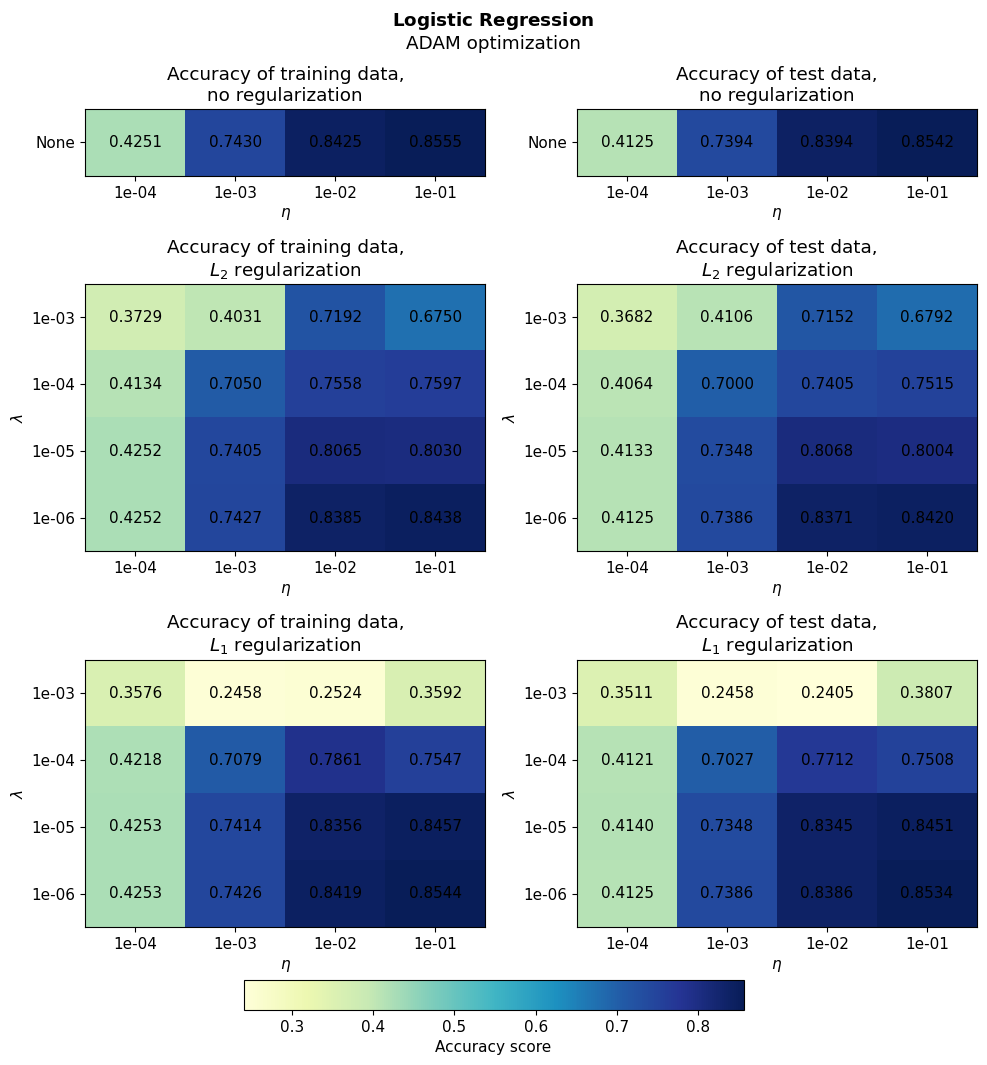

In [8]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10), height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg[np.newaxis,:], acc_test_matrix_no_reg[np.newaxis,:], acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    #im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='summer_r', vmin=vmin, vmax=vmax)
    im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    # Set x-ticks
    ax.set_xticks(range(len(etas)))
    ax.set_xticklabels([f"{y:.0e}" for y in etas])
    ax.set_xlabel(r"$\eta$")

    # Set y-ticks
    if matrices[i].shape[0] == 1:  # no regularization (single row)
        ax.set_yticks([0])
        ax.set_yticklabels(["None"])
    else:
        ax.set_yticks(range(len(lambdas)))
        ax.set_yticklabels([f"{x:.0e}" for x in lambdas])
        ax.set_ylabel(r"$\lambda$")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color="black", fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")

plt.suptitle(r"$\bf{Logistic\ Regression}$"+"\nADAM optimization")
fig.tight_layout()
#plt.savefig("Logistic_reg.png", bbox_inches="tight")
plt.show()


In [9]:
import autograd.numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from functions.ffnn import *
from functions.activation_funcs import *
from functions.cost_functions import * 

y=targets

# ------------------------------------------------------------
# 1. Split and scale data
# ------------------------------------------------------------
X_train, X_test, t_train, t_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Scale inputs only (standard for classifiers)
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------------------------------------------
# 3. Training parameters
# ------------------------------------------------------------
netas = 4                                # number of learning rates
etas = np.logspace(-4, -1, netas)        # 1e-4 ... 1e-1

epochs = 20
M = 128                                  # mini-batch size
beta1, beta2 = 0.9, 0.999                # ADAM hyperparameters

input_size = X_train.shape[1]
output_size = t_train.shape[1]


# Network architecture
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]

# Acc results
acc_train_matrix_no_reg = np.zeros(netas)
acc_test_matrix_no_reg = np.zeros(netas)

# ------------------------------------------------------------
# 4. Accuracy function
# ------------------------------------------------------------
def accuracy(model, X, t):
    predictions = model._feed_forward(X)
    pred_class = np.argmax(predictions, axis=1)
    true_class = np.argmax(t, axis=1)
    return np.mean(pred_class == true_class)

# ------------------------------------------------------------
# 5. Learning rate loop
# ------------------------------------------------------------
for i in range(netas):
    eta = etas[i]
    print(f"Training with η = {eta}")

    # Create a new network for each learning rate
    nn = NeuralNetwork(
        network_input_size=input_size,
        layer_output_sizes=layer_sizes,
        activation_funcs=activation_funcs,
        activation_ders=activation_ders,
        cost_fun=cross_entropy,
        cost_der=cross_entropy_der
    )

    # Train model using SGD + ADAM
    nn.train_SGD(
        X_train,
        t_train,
        epochs=epochs,
        learning_rate=eta,
        batch_size=M,
        optimizer="Adam"
    )

    # Evaluate
    acc_train_matrix_no_reg[i] = accuracy(nn, X_train, t_train)
    acc_test_matrix_no_reg[i] = accuracy(nn, X_test, t_test)

    print(f"→ Train acc: {acc_train_matrix_no_reg[i]:.3f}, Test acc: {acc_test_matrix_no_reg[i]:.3f}\n")


Training with η = 0.0001
→ Train acc: 0.236, Test acc: 0.252

Training with η = 0.001
→ Train acc: 0.752, Test acc: 0.756

Training with η = 0.01
→ Train acc: 0.840, Test acc: 0.836

Training with η = 0.1
→ Train acc: 0.850, Test acc: 0.848



In [10]:
import autograd.numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from functions.ffnn import *
from functions.activation_funcs import *
from functions.cost_functions import *

# ------------------------------------------------------------
# 1. Split and scale data
# ------------------------------------------------------------
X_train, X_test, t_train, t_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------------------------------------------
# 2. Training parameters
# ------------------------------------------------------------
nlambdas = 4
lambdas = np.logspace(-6, -3, nlambdas)

netas = 4
etas = np.logspace(-4, -1, netas)

epochs = 20
M = 128

input_size = X_train.shape[1]
output_size = t_train.shape[1]

# ------------------------------------------------------------
# 3. Network architecture (example: softmax output only)
#    You can add hidden layers if you want.
# ------------------------------------------------------------
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]

# ------------------------------------------------------------
# 4. Accuracy metric
# ------------------------------------------------------------
def accuracy(model, X, t):
    predictions = model._feed_forward(X)
    pred_class = np.argmax(predictions, axis=1)
    true_class = np.argmax(t, axis=1)
    return np.mean(pred_class == true_class)

# ------------------------------------------------------------
# 5. Matrices to store accuracy for (η, λ) combinations
# ------------------------------------------------------------
acc_train_matrix_L2 = np.zeros((netas, nlambdas))
acc_test_matrix_L2  = np.zeros((netas, nlambdas))

# ------------------------------------------------------------
# 6. Grid search over η and λ
# ------------------------------------------------------------
for i in range(netas):
    eta = etas[i]
    print(f"\n===== Learning rate η = {eta} =====")

    for j in range(nlambdas):
        lmb = lambdas[j]
        print(f"  → Testing λ = {lmb}")

        # -----------------------------
        # Create NEW network each time!
        # -----------------------------
        nn = NeuralNetwork(
            network_input_size = input_size,
            layer_output_sizes = layer_sizes,
            activation_funcs   = activation_funcs,
            activation_ders    = activation_ders,
            cost_fun           = cross_entropy,
            cost_der           = cross_entropy_der,
            lamb               = lmb,
            cost_fun_type      = "L2"
        )

        # -----------------------------
        # Train using SGD + Adam
        # -----------------------------
        nn.train_SGD(
            X_train,
            t_train,
            epochs      = epochs,
            learning_rate = eta,
            batch_size  = M,
            optimizer   = "Adam"
        )

        # -----------------------------
        # Evaluate
        # -----------------------------
        acc_train_matrix_L2[i, j] = accuracy(nn, X_train, t_train)
        acc_test_matrix_L2[i, j]  = accuracy(nn, X_test,  t_test)

        print(f"     Train acc = {acc_train_matrix_L2[i,j]:.3f}, Test acc = {acc_test_matrix_L2[i,j]:.3f}")



===== Learning rate η = 0.0001 =====
  → Testing λ = 1e-06
     Train acc = 0.243, Test acc = 0.228
  → Testing λ = 1e-05
     Train acc = 0.243, Test acc = 0.228
  → Testing λ = 0.0001
     Train acc = 0.243, Test acc = 0.228
  → Testing λ = 0.001
     Train acc = 0.243, Test acc = 0.228

===== Learning rate η = 0.001 =====
  → Testing λ = 1e-06
     Train acc = 0.754, Test acc = 0.748
  → Testing λ = 1e-05
     Train acc = 0.754, Test acc = 0.748
  → Testing λ = 0.0001
     Train acc = 0.754, Test acc = 0.748
  → Testing λ = 0.001
     Train acc = 0.754, Test acc = 0.748

===== Learning rate η = 0.01 =====
  → Testing λ = 1e-06
     Train acc = 0.841, Test acc = 0.845
  → Testing λ = 1e-05
     Train acc = 0.841, Test acc = 0.845
  → Testing λ = 0.0001
     Train acc = 0.841, Test acc = 0.845
  → Testing λ = 0.001
     Train acc = 0.840, Test acc = 0.845

===== Learning rate η = 0.1 =====
  → Testing λ = 1e-06
     Train acc = 0.857, Test acc = 0.861
  → Testing λ = 1e-05
     Train

In [11]:
import autograd.numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from functions.ffnn import *
from functions.activation_funcs import *
from functions.cost_functions import *

# ------------------------------------------------------------
# 1. Split and scale data
# ------------------------------------------------------------
X_train, X_test, t_train, t_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------------------------------------------
# 2. Training parameters
# ------------------------------------------------------------
nlambdas = 4
lambdas = np.logspace(-6, -3, nlambdas)

netas = 4
etas = np.logspace(-4, -1, netas)

epochs = 20
M = 128

input_size = X_train.shape[1]
output_size = t_train.shape[1]

# ------------------------------------------------------------
# 3. Network architecture (example: softmax output only)
#    You can add hidden layers if you want.
# ------------------------------------------------------------
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]

# ------------------------------------------------------------
# 4. Accuracy metric
# ------------------------------------------------------------
def accuracy(model, X, t):
    predictions = model._feed_forward(X)
    pred_class = np.argmax(predictions, axis=1)
    true_class = np.argmax(t, axis=1)
    return np.mean(pred_class == true_class)

# ------------------------------------------------------------
# 5. Matrices to store accuracy for (η, λ) combinations
# ------------------------------------------------------------
acc_train_matrix_L1 = np.zeros((netas, nlambdas))
acc_test_matrix_L1  = np.zeros((netas, nlambdas))

# ------------------------------------------------------------
# 6. Grid search over η and λ
# ------------------------------------------------------------
for i in range(netas):
    eta = etas[i]
    print(f"\n===== Learning rate η = {eta} =====")

    for j in range(nlambdas):
        lmb = lambdas[j]
        print(f"  → Testing λ = {lmb}")

        # -----------------------------
        # Create NEW network each time!
        # -----------------------------
        nn = NeuralNetwork(
            network_input_size = input_size,
            layer_output_sizes = layer_sizes,
            activation_funcs   = activation_funcs,
            activation_ders    = activation_ders,
            cost_fun           = cross_entropy,
            cost_der           = cross_entropy_der,
            lamb               = lmb,
            cost_fun_type      = "L1"
        )

        # -----------------------------
        # Train using SGD + Adam
        # -----------------------------
        nn.train_SGD(
            X_train,
            t_train,
            epochs      = epochs,
            learning_rate = eta,
            batch_size  = M,
            optimizer   = "Adam"
        )

        # -----------------------------
        # Evaluate
        # -----------------------------
        acc_train_matrix_L1[i, j] = accuracy(nn, X_train, t_train)
        acc_test_matrix_L1[i, j]  = accuracy(nn, X_test,  t_test)

        print(f"     Train acc = {acc_train_matrix_L1[i,j]:.3f}, Test acc = {acc_test_matrix_L1[i,j]:.3f}")



===== Learning rate η = 0.0001 =====
  → Testing λ = 1e-06
     Train acc = 0.243, Test acc = 0.228
  → Testing λ = 1e-05
     Train acc = 0.243, Test acc = 0.228
  → Testing λ = 0.0001
     Train acc = 0.243, Test acc = 0.228
  → Testing λ = 0.001
     Train acc = 0.243, Test acc = 0.228

===== Learning rate η = 0.001 =====
  → Testing λ = 1e-06
     Train acc = 0.754, Test acc = 0.748
  → Testing λ = 1e-05
     Train acc = 0.754, Test acc = 0.748
  → Testing λ = 0.0001
     Train acc = 0.754, Test acc = 0.748
  → Testing λ = 0.001
     Train acc = 0.754, Test acc = 0.748

===== Learning rate η = 0.01 =====
  → Testing λ = 1e-06
     Train acc = 0.841, Test acc = 0.845
  → Testing λ = 1e-05
     Train acc = 0.841, Test acc = 0.845
  → Testing λ = 0.0001
     Train acc = 0.841, Test acc = 0.845
  → Testing λ = 0.001
     Train acc = 0.841, Test acc = 0.845

===== Learning rate η = 0.1 =====
  → Testing λ = 1e-06
     Train acc = 0.857, Test acc = 0.861
  → Testing λ = 1e-05
     Train

C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_9232\71406244.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


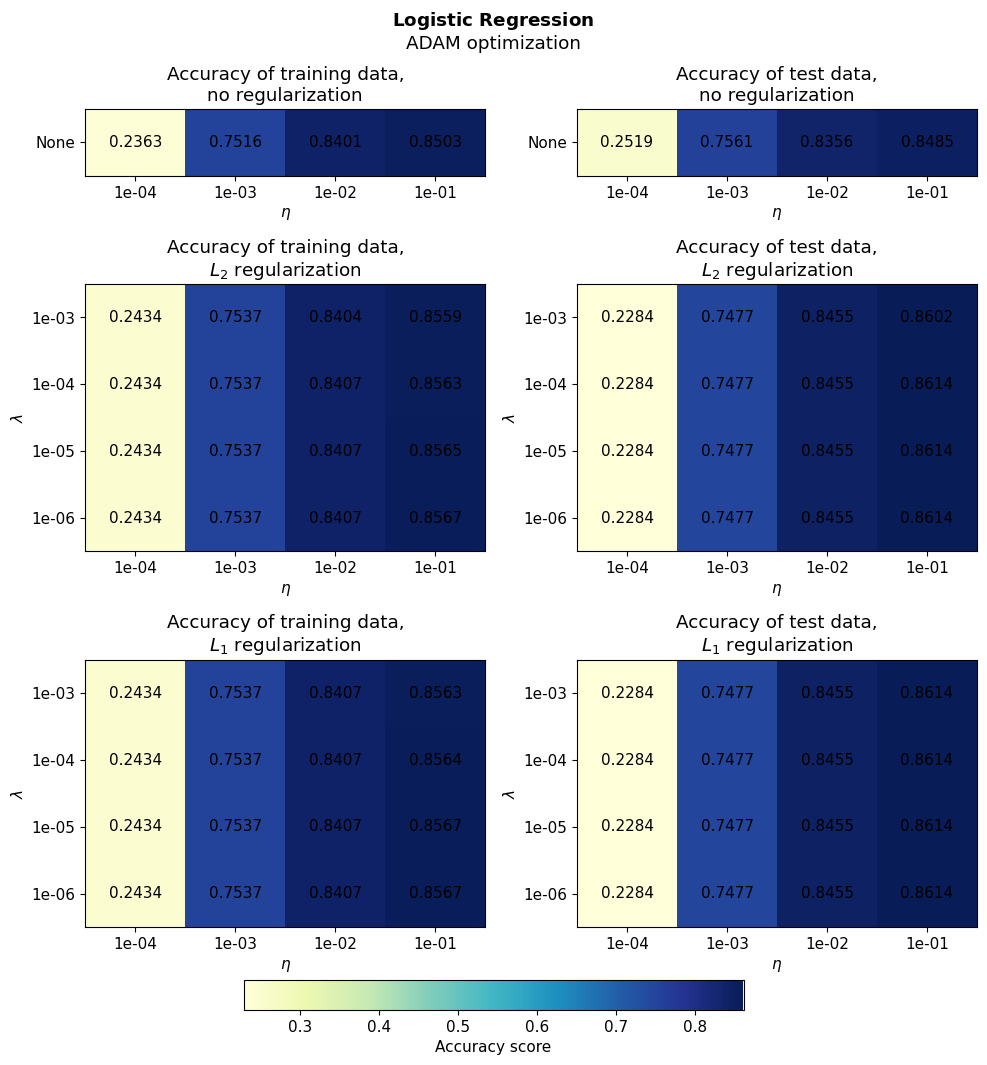

In [12]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10), height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg[np.newaxis,:], acc_test_matrix_no_reg[np.newaxis,:], acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    #im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='summer_r', vmin=vmin, vmax=vmax)
    im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    # Set x-ticks
    ax.set_xticks(range(len(etas)))
    ax.set_xticklabels([f"{y:.0e}" for y in etas])
    ax.set_xlabel(r"$\eta$")

    # Set y-ticks
    if matrices[i].shape[0] == 1:  # no regularization (single row)
        ax.set_yticks([0])
        ax.set_yticklabels(["None"])
    else:
        ax.set_yticks(range(len(lambdas)))
        ax.set_yticklabels([f"{x:.0e}" for x in lambdas])
        ax.set_ylabel(r"$\lambda$")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color="black", fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")

plt.suptitle(r"$\bf{Logistic\ Regression}$"+"\nADAM optimization")
fig.tight_layout()
#plt.savefig("Logistic_reg.png", bbox_inches="tight")
plt.show()


In [13]:
"""
import autograd.numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# 1. Split and scale data
# ------------------------------------------------------------
X_train, X_test, t_train, t_test = train_test_split(X, y_onehot, test_size=0.2, random_state=123)

# Scale inputs only (standard for classifiers)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------------------------------------------------
# 2. Define activation functions and derivatives
# ------------------------------------------------------------
def relu(x):
    return np.maximum(0, x)

def relu_der(x):
    return (x > 0).astype(float)

def softmax(x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

def softmax_der(x):  
    # Only used when not combining softmax + CE
    s = softmax(x)
    return s * (1 - s)

# ------------------------------
# Cost: Cross-entropy + derivative
# ------------------------------
def cross_entropy(pred, target):
    eps = 1e-12
    return -np.sum(target * np.log(pred + eps)) / pred.shape[0]

def cross_entropy_der(pred, target):
    eps = 1e-12
    return -(target / (pred + eps)) / pred.shape[0]

# ------------------------------------------------------------
# 3. Training parameters
# ------------------------------------------------------------
netas = 4                                # number of learning rates
etas = np.logspace(-4, -1, netas)        # 1e-4 ... 1e-1

epochs = 20
M = 64                                   # mini-batch size
beta1, beta2 = 0.9, 0.999                # ADAM hyperparameters

input_size = X_train.shape[1]
output_size = t_train.shape[1]

hidden_size = 20                         # example; adjust as needed

# Network architecture
layer_sizes = [hidden_size, output_size]
activation_funcs = [relu, softmax]
activation_ders = [relu_der, softmax_der]

# Acc results
acc_train = np.zeros(netas)
acc_test = np.zeros(netas)

# ------------------------------------------------------------
# 4. Accuracy function
# ------------------------------------------------------------
def accuracy(model, X, t):
    predictions = model._feed_forward(X)
    pred_class = np.argmax(predictions, axis=1)
    true_class = np.argmax(t, axis=1)
    return np.mean(pred_class == true_class)

# ------------------------------------------------------------
# 5. Learning rate loop
# ------------------------------------------------------------
for i in range(netas):
    eta = etas[i]
    print(f"Training with η = {eta}")

    # Create a new network for each learning rate
    nn = NeuralNetwork(
        network_input_size=input_size,
        layer_output_sizes=layer_sizes,
        activation_funcs=activation_funcs,
        activation_ders=activation_ders,
        cost_fun=cross_entropy,
        cost_der=cross_entropy_der,
        cost_fun_type="none"
    )

    # Train model using SGD + ADAM
    nn.train_SGD(
        X_train,
        t_train,
        epochs=epochs,
        learning_rate=eta,
        batch_size=M,
        optimizer="Adam"
    )

    # Evaluate
    acc_train[i] = accuracy(nn, X_train, t_train)
    acc_test[i] = accuracy(nn, X_test, t_test)

    print(f"→ Train acc: {acc_train[i]:.3f}, Test acc: {acc_test[i]:.3f}\n")
"""


'\nimport autograd.numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\n\n# ------------------------------------------------------------\n# 1. Split and scale data\n# ------------------------------------------------------------\nX_train, X_test, t_train, t_test = train_test_split(X, y_onehot, test_size=0.2, random_state=123)\n\n# Scale inputs only (standard for classifiers)\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\n# ------------------------------------------------------------\n# 2. Define activation functions and derivatives\n# ------------------------------------------------------------\ndef relu(x):\n    return np.maximum(0, x)\n\ndef relu_der(x):\n    return (x > 0).astype(float)\n\ndef softmax(x):\n    e = np.exp(x - np.max(x, axis=1, keepdims=True))\n    return e / np.sum(e, axis=1, keepdims=True)\n\ndef softmax_der(x):  \n    # Only used when not combin

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List

class WeatherNN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int = None,
        num_hidden_layers: int = None,
        activation: str = None
    ):  
        
        super().__init__()
        

        self.cost = nn.CrossEntropyLoss()
        #self.output_layer = nn.Softmax()
        
        if num_hidden_layers:
            # Choose activation function
            activations = {
                "relu": nn.ReLU(),
                "lrelu": nn.LeakyReLU(),
                "sigmoid": nn.Sigmoid(),
                "tanh": nn.Tanh(),
                "elu": nn.ELU()
            }
            act = activations[activation.lower()]

            layers = []

            # Input layer
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(act)
        
            # Hidden layers
            for h in range(num_hidden_layers - 1):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(act)

            # Output layer
            layers.append(nn.Linear(hidden_dim, output_dim))
            #layers.append(nn.Softmax(dim=1))

        
        else:
            layers = []
            # Input layer
            layers.append(nn.Linear(input_dim, output_dim))

        self.model = nn.Sequential(*layers)
    
    def get_model(self):
        return self.model
    
    def forward(self, x):
        return self.model(x)
    
    def train_model(self, train_loader, lr: float, epochs: int, lmb: float=None, reg_type: str = None):
        """
        reg_type: None, "L1", or "L2"
        """
        if reg_type == "L2":
            optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=lmb)
        else:
            optimizer = optim.Adam(self.parameters(), lr=lr)

        for e in range(epochs):
            for X, y in train_loader:
                optimizer.zero_grad()
                outputs = self.forward(X)
                loss = self.cost(outputs, y)

                if reg_type == "L1":
                    penalty = 0
                    for param in self.parameters():
                        penalty += torch.sum(torch.abs(param))
                    loss += lmb * penalty
                    
                loss.backward()
                optimizer.step()
    
    def evaluate(self, loader):
        self.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in loader:
                outputs=self.forward(X) 
                preds = outputs.argmax(dim=1) 
                correct += (preds == y).sum().item()
                total += y.size(0)

        return correct / total


        

In [15]:
path = '/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/kagglehub/datasets/nikhil7280/weather-type-classification/versions/1/weather_classification_data.csv'
dataset = WeatherDataset(csv_file=path)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
    
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [16]:
import numpy as np
from torch.utils.data import DataLoader
seed = 2018

# create loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

# learning rates
netas = 4
etas = np.logspace(-4, -1, netas)

acc_train_matrix_no_reg = np.zeros(netas)
acc_test_matrix_no_reg = np.zeros(netas)

epochs = 20

# number of features and classes
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))

for i in range(netas):
    eta = etas[i]

    # fresh model for each η
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    model = WeatherNN(input_dim, output_dim)

    # train
    model.train_model(train_loader, lr=eta, epochs=epochs)

    # eval
    acc_train_matrix_no_reg[i] = model.evaluate(train_loader)
    acc_test_matrix_no_reg[i]  = model.evaluate(test_loader)

print("Train:", acc_train_matrix_no_reg)
print("Test:",  acc_test_matrix_no_reg)


Train: [0.27613636 0.84602273 0.69479167 0.78229167]
Test: [0.27613636 0.8655303  0.70530303 0.80416667]


In [17]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get feature dimension + number of classes
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))

# ------------------------------------------------------------
# 3. Set up (η, λ) grid
# ------------------------------------------------------------
nlambdas = 4
lambdas = np.logspace(-6, -3, nlambdas)

netas = 4
etas = np.logspace(-4, -1, netas)

acc_train_matrix_L2 = np.zeros((netas, nlambdas))
acc_test_matrix_L2  = np.zeros((netas, nlambdas))

epochs = 20

# ------------------------------------------------------------
# 4. Grid search
# ------------------------------------------------------------
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        model = WeatherNN(input_dim, output_dim)

        # train with given η, λ
        model.train_model(train_loader,
                    lr=eta,
                    epochs=epochs,
                    lmb = lmb,
                    reg_type = "L2")

        # evaluate
        acc_train_matrix_L2[i, j] = model.evaluate(train_loader)
        acc_test_matrix_L2[i, j]  = model.evaluate(test_loader)

        print(f"η={eta:.1e}, λ={lmb:.1e} → "
              f"train={acc_train_matrix_L2[i,j]:.3f}, test={acc_test_matrix_L2[i,j]:.3f}")

η=1.0e-04, λ=1.0e-06 → train=0.276, test=0.276
η=1.0e-04, λ=1.0e-05 → train=0.276, test=0.276
η=1.0e-04, λ=1.0e-04 → train=0.276, test=0.276
η=1.0e-04, λ=1.0e-03 → train=0.276, test=0.276
η=1.0e-03, λ=1.0e-06 → train=0.846, test=0.866
η=1.0e-03, λ=1.0e-05 → train=0.846, test=0.866
η=1.0e-03, λ=1.0e-04 → train=0.846, test=0.866
η=1.0e-03, λ=1.0e-03 → train=0.846, test=0.866
η=1.0e-02, λ=1.0e-06 → train=0.695, test=0.705
η=1.0e-02, λ=1.0e-05 → train=0.695, test=0.705
η=1.0e-02, λ=1.0e-04 → train=0.695, test=0.705
η=1.0e-02, λ=1.0e-03 → train=0.694, test=0.705
η=1.0e-01, λ=1.0e-06 → train=0.678, test=0.689
η=1.0e-01, λ=1.0e-05 → train=0.608, test=0.617
η=1.0e-01, λ=1.0e-04 → train=0.766, test=0.778
η=1.0e-01, λ=1.0e-03 → train=0.723, test=0.731


In [18]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get feature dimension + number of classes
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))

# ------------------------------------------------------------
# 3. Set up (η, λ) grid
# ------------------------------------------------------------
nlambdas = 4
lambdas = np.logspace(-6, -3, nlambdas)

netas = 4
etas = np.logspace(-4, -1, netas)

acc_train_matrix_L1 = np.zeros((netas, nlambdas))
acc_test_matrix_L1  = np.zeros((netas, nlambdas))

epochs = 20

# ------------------------------------------------------------
# 4. Grid search
# ------------------------------------------------------------
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        model = WeatherNN(input_dim, output_dim)

        # train with given η, λ
        model.train_model(train_loader,
                    lr=eta,
                    epochs=epochs,
                    lmb = lmb,
                    reg_type = "L1")

        # evaluate
        acc_train_matrix_L1[i, j] = model.evaluate(train_loader)
        acc_test_matrix_L1[i, j]  = model.evaluate(test_loader)

        print(f"η={eta:.1e}, λ={lmb:.1e} → "
              f"train={acc_train_matrix_L1[i,j]:.3f}, test={acc_test_matrix_L1[i,j]:.3f}")

η=1.0e-04, λ=1.0e-06 → train=0.276, test=0.276
η=1.0e-04, λ=1.0e-05 → train=0.276, test=0.276
η=1.0e-04, λ=1.0e-04 → train=0.276, test=0.276
η=1.0e-04, λ=1.0e-03 → train=0.276, test=0.276
η=1.0e-03, λ=1.0e-06 → train=0.846, test=0.866
η=1.0e-03, λ=1.0e-05 → train=0.846, test=0.866
η=1.0e-03, λ=1.0e-04 → train=0.846, test=0.866
η=1.0e-03, λ=1.0e-03 → train=0.846, test=0.865
η=1.0e-02, λ=1.0e-06 → train=0.695, test=0.705
η=1.0e-02, λ=1.0e-05 → train=0.695, test=0.705
η=1.0e-02, λ=1.0e-04 → train=0.695, test=0.705
η=1.0e-02, λ=1.0e-03 → train=0.691, test=0.702
η=1.0e-01, λ=1.0e-06 → train=0.531, test=0.534
η=1.0e-01, λ=1.0e-05 → train=0.470, test=0.460
η=1.0e-01, λ=1.0e-04 → train=0.627, test=0.636
η=1.0e-01, λ=1.0e-03 → train=0.656, test=0.662


C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_9232\71406244.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


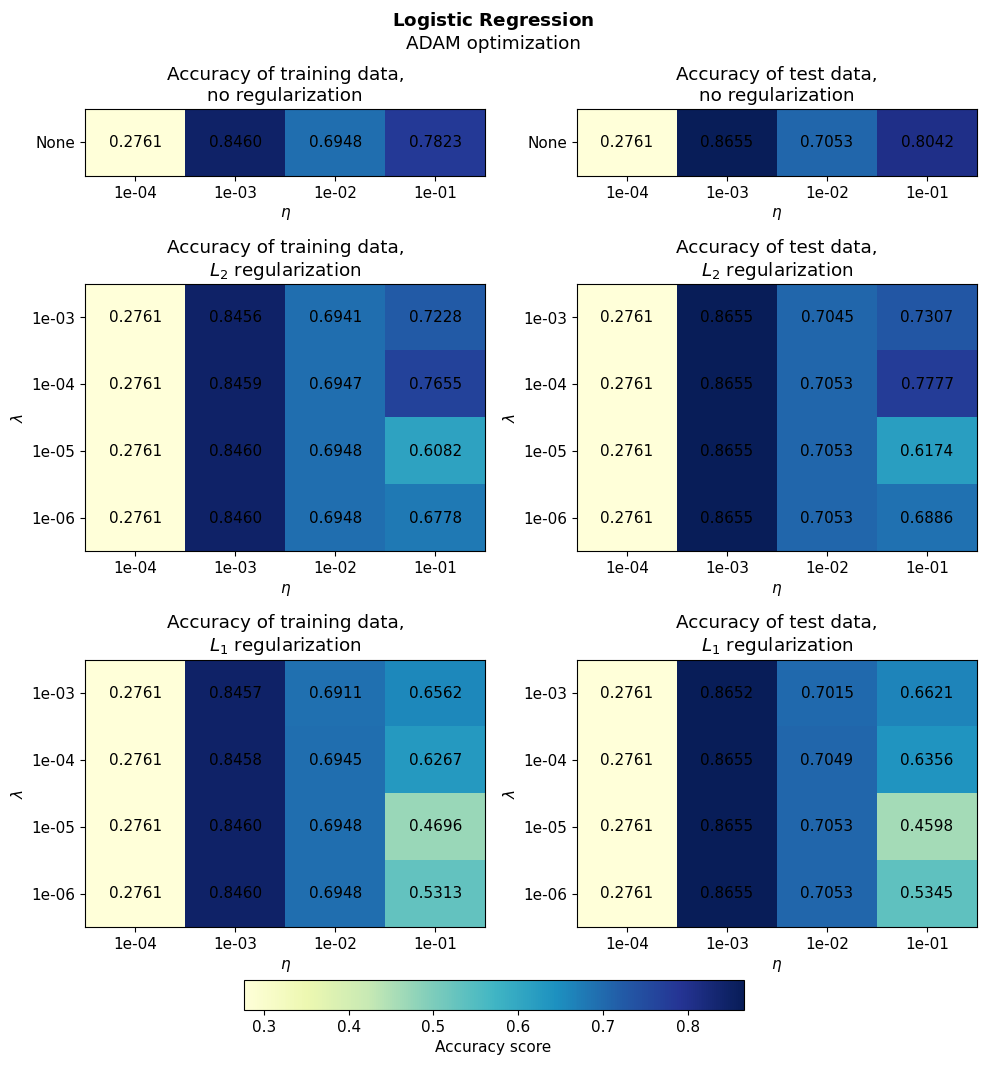

In [19]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10), height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg[np.newaxis,:], acc_test_matrix_no_reg[np.newaxis,:], acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    #im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='summer_r', vmin=vmin, vmax=vmax)
    im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    # Set x-ticks
    ax.set_xticks(range(len(etas)))
    ax.set_xticklabels([f"{y:.0e}" for y in etas])
    ax.set_xlabel(r"$\eta$")

    # Set y-ticks
    if matrices[i].shape[0] == 1:  # no regularization (single row)
        ax.set_yticks([0])
        ax.set_yticklabels(["None"])
    else:
        ax.set_yticks(range(len(lambdas)))
        ax.set_yticklabels([f"{x:.0e}" for x in lambdas])
        ax.set_ylabel(r"$\lambda$")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color="black", fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")

plt.suptitle(r"$\bf{Logistic\ Regression}$"+"\nADAM optimization")
fig.tight_layout()
#plt.savefig("Logistic_reg.png", bbox_inches="tight")
plt.show()
